# Implementing Cross-Validation for Time Series Data

This notebook illustrates how to implement **time-series cross-validation** (rolling forecast):

## Steps:

1. **Split Data Chronologically**:
   - Divide the data into folds based on chronological order.

2. **Train and Test**:
   - For each fold, train the model on all data up to time $ t $.
   - Test the model on the next window of data.

3. **Slide the Window Forward**:
   - Move the training and testing windows forward to cover the entire dataset.

Using this approach to cross-validation ensures that the temporal ordering of the data is preserved and avoids look-ahead bias, making it suitable for time series analysis.


## Method 1. Manual rolling-forecast CV  

Below, we illustrate a manual scheme for implementing cross-validation for a time series to ensure that every test set occurs strictly after its training set in time, avoiding look-ahead bias.

### Steps:

1. **Initial Train/Test Split**
   - Split your chronological data into a large **training segment** (e.g., 80% of the earliest observations) and a **final test segment** (the most recent 20%). This final test segment simulates future unseen data.

2. **Sliding-Window CV on Training Data**
   - Choose a fixed window length $ \Delta t $ for both training and validation.
   - For fold $ i $:
     - Train on the earliest $ \Delta t \times i $ observations.
     - Validate on the next $ \Delta t $ observations.
   - Slide forward by $ \Delta t $ and repeat until you exhaust the training period.


In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 1. Time series data with simple trend + noise series
np.random.seed(0)
n = 200
time = np.arange(n)
y = 0.1 * time + np.sin(time / 10) + np.random.normal(scale=0.5, size=n)
df = pd.DataFrame({'t': time, 'y': y})

# 2. Define rolling-forecast cross-validation parameters
n_splits = 5         # number of folds
test_size = 20       # size of each test window

# 3. Perform manual rolling-forecast CV
errors = []

for split in range(n_splits):
    # a) Determine train and test indices
    train_end = n - (n_splits - split) * test_size
    test_start = train_end
    test_end = test_start + test_size

    train_idx = range(0, train_end)
    test_idx  = range(test_start, test_end)

    # b) Split into train/test sets
    X_train = df.loc[train_idx, ['t']]
    y_train = df.loc[train_idx, 'y']
    X_test  = df.loc[test_idx, ['t']]
    y_test  = df.loc[test_idx, 'y']

    # c) Fit a simple model (e.g., linear regression)
    model = LinearRegression()
    model.fit(X_train, y_train)

    # d) Predict and evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    errors.append(mse)

    print(f"Fold {split+1}: Train up to t<{train_end}, "
          f"Test t∈[{test_start},{test_end}) → MSE = {mse:.4f}")

# 4. Overall performance
print(f"\nAverage MSE over {n_splits} folds: {np.mean(errors):.4f}")


Fold 1: Train up to t<100, Test t∈[100,120) → MSE = 0.7315
Fold 2: Train up to t<120, Test t∈[120,140) → MSE = 0.9843
Fold 3: Train up to t<140, Test t∈[140,160) → MSE = 0.9886
Fold 4: Train up to t<160, Test t∈[160,180) → MSE = 1.1726
Fold 5: Train up to t<180, Test t∈[180,200) → MSE = 1.0709

Average MSE over 5 folds: 0.9896


### Explanation of the steps:

1. Assume a time series data `y` with a trend plus noise.  

2. Define Cross-Validation Parameters: choose the number of folds (`n_splits`) and the size of each test window (`test_size`). These parameters control the granularity of the cross-validation process

3. Perform Rolling-Window Cross-Validation:
For each fold:  
   - set the training data from the start up to `train_end`, and set the test data from `train_end` to `train_end + test_size`.  
   - then fit a model on the training window and evaluate on the immediate next window.  
   - Accumulate the mean squared error (MSE) for each fold to assess the model's performance.

4. Finally, report the average MSE across folds.
This provides an overall measure of the model's performance on the time series data.


### Python Code

with visualization of the original data, training data, test data, and predictions.


## Method 2. Using `TimeSeriesSplit` for Sliding-Window CV implemented in Scikit-Learn

Scikit-Learn provides the `TimeSeriesSplit` class to implement sliding-window (rolling) cross-validation for time-ordered data. This built-in function ensures that you never train on future data, making it easy to implement sliding-window cross-validation in your time-series workflows.

We'll use a 5-fold CV (`n_splits=5`) and select `max_train_size=50` - an optional parameter that sets the maximum size of the training set. If the training set exceeds this size, older observations are dropped as the window slides forward. This ensures that the training set does not grow indefinitely. The `tscv.split(X)` method returns an iterator that yields tuples of training and testing indices for each fold.


Fold 1: Train indices 0–19, Test indices 20–35 → MSE = 1.8462
Fold 2: Train indices 0–35, Test indices 36–51 → MSE = 1.2184
Fold 3: Train indices 2–51, Test indices 52–67 → MSE = 0.5260
Fold 4: Train indices 18–67, Test indices 68–83 → MSE = 0.8033
Fold 5: Train indices 34–83, Test indices 84–99 → MSE = 1.6418


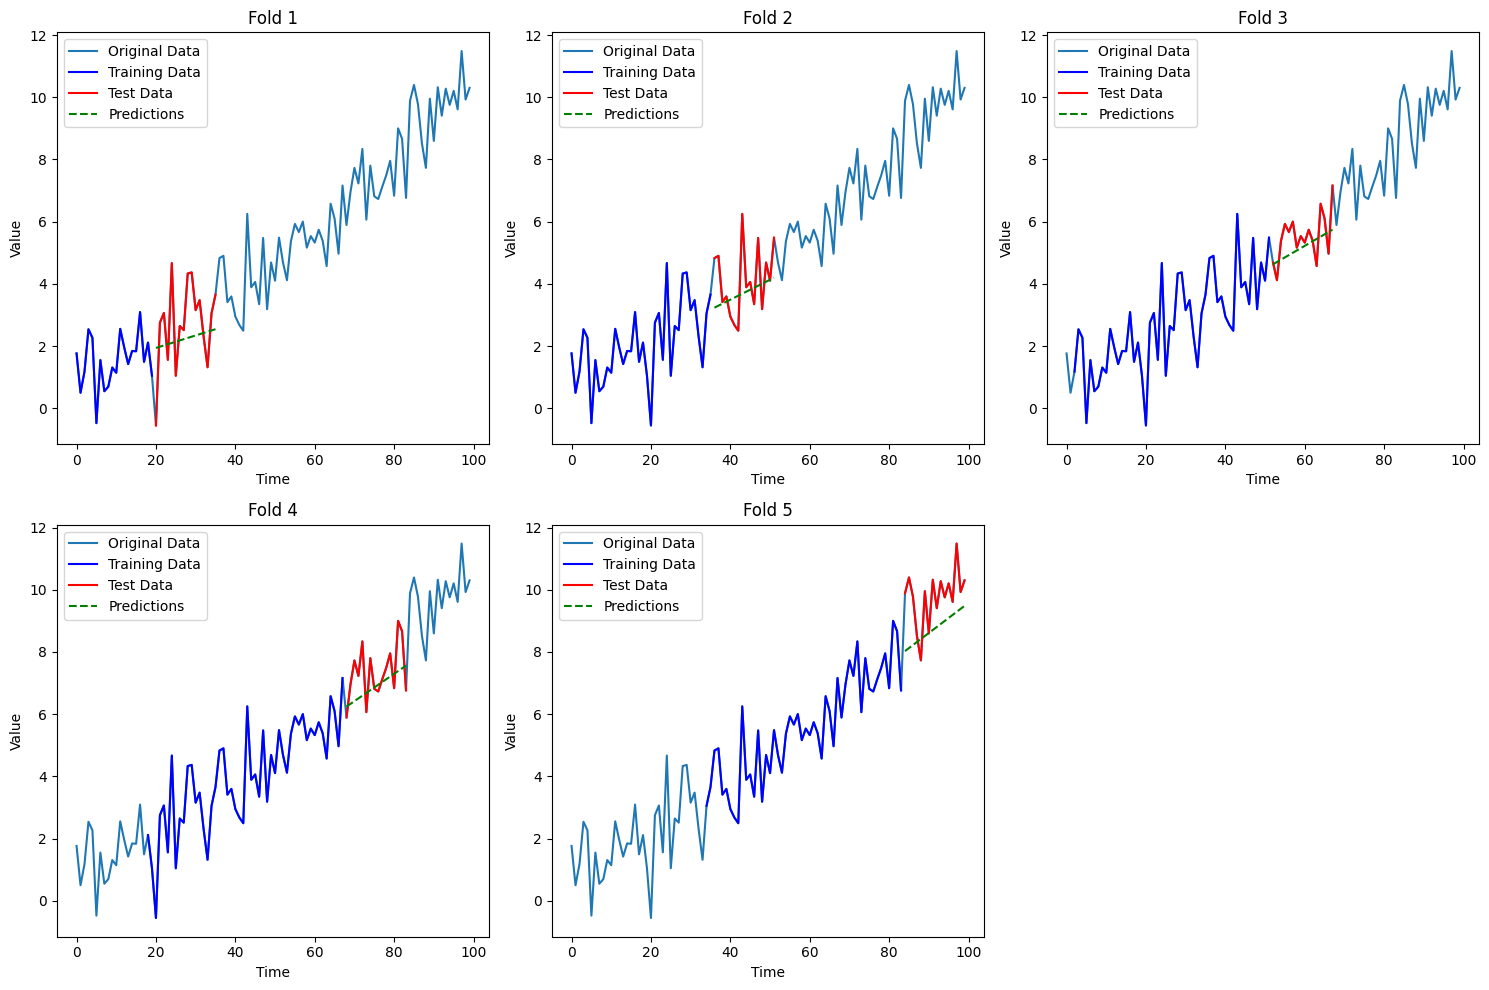


Average MSE over 5 folds: 1.2071


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 1. Time-series data `y`
np.random.seed(0)
n = 100
time = np.arange(n)
y = 0.1 * time + np.random.normal(scale=1.0, size=n)
X = pd.DataFrame({'t': time})

# 2. Initialize TimeSeriesSplit params
#    n_splits = number of folds
#    max_train_size = optional fixed training window length
tscv = TimeSeriesSplit(n_splits=5, max_train_size=50)

# 3. Perform sliding-window CV
mse_scores = []  # List to store MSE scores for each fold

plt.figure(figsize=(15, 10))

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)  # Store the MSE score for this fold

    # Plot the results for each fold
    plt.subplot(2, 3, fold + 1)
    plt.plot(X['t'], y, label='Original Data')
    plt.plot(X_train['t'], y_train, label='Training Data', color='blue')
    plt.plot(X_test['t'], y_test, label='Test Data', color='red')
    plt.plot(X_test['t'], y_pred, label='Predictions', color='green', linestyle='--')
    plt.title(f'Fold {fold+1}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

    print(f"Fold {fold+1}: Train indices {train_idx[0]}–{train_idx[-1]}, "
          f"Test indices {test_idx[0]}–{test_idx[-1]} → MSE = {mse:.4f}")

plt.tight_layout()
plt.show()

# 4. Calculate and print the average MSE
average_mse = np.mean(mse_scores)
print(f"\nAverage MSE over {len(mse_scores)} folds: {average_mse:.4f}")


# Summary

This notebook provides a clear guide to implementing time series cross-validation using both manual methods and Scikit-Learn’s `TimeSeriesSplit`, with visualizations to aid understanding and evaluation.

## Methods:

1. **Manual Implementation**:
   - Steps to manually perform rolling forecast cross-validation.

2. **Using Scikit-Learn’s `TimeSeriesSplit`**:
   - Introduction to `TimeSeriesSplit` for sliding-window cross-validation.
   - Key parameters: `n_splits`, `max_train_size`, and `test_size`.
   - Example code and visualizations for each fold.

The overall performance is evaluated using the average Mean Squared Error (MSE).

